# Bootstrapping

The principle of bootstrapping is to assume that our sampling population $\mathbf{x} = [x_1, \ldots, x_N]^T$ is a faithful representation of the data.
Therefore, can simulate multiple training sets by bootstrap replicates (Efron and Tibshirani (1993)).
In practice, we assume that approximated pdf provided by the histogram is a reasonable representation of our distribution. Therefore, sampling from the pdf will be performed according to the approaximated pdf.

As we have already seen, the histogram allows us an empirical estimation of the cumulative distribution function $F(x) = \int_{-\infty}^x f(t)\, dt$ as :

$$ \hat{F_n}(x) = \frac{1}{N}\sum_{i=1}^N I(t_i\leq x)$$


A bootstrap sample is a sample taken __with replacement__ from the empirical cdf $\hat{F_n}$. Let's denote this sample as $\mathbf{x^*} = [x_1^*, \ldots, x_N^*]^T$. Any statistic on the underlying, unknown distribution, $\hat{\theta\,} = T(\mathbf{x})$, will be replaced by the the bootstrap estimate of the statistic $\hat{\theta^*} = T(\mathbf{x}^*)$. By repeating the boostrap process for many times, we can obtain an empirical distributions of bootstrap estimates $\hat{\theta_1^*}, \ldots, \hat{\theta_B^*}$. The distribution of the bootstrap estimates is an ideal approximation of the sampling distribution of $\hat{\theta\,}$, and can be used to quantify the uncertainty in our estimate, as well as to perform parameter inference.

Here is a simple example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# our data is 100 samples generated from a N(0,1) Gaussian
x = np.random.randn(100)

# 10 bootstrap repetitions 
B = 10

# We generate our bootstrap data by sampling **with replacement** from our data
bootstrap_sample = np.random.choice(x, size = [len(x),B] , replace = True)
print('The size of our bootstrap sample is' + str(bootstrap_sample.shape))




The size of our bootstrap sample is(100, 10)


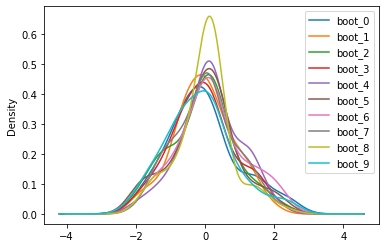

In [2]:
import pandas as pd

df = pd.DataFrame(bootstrap_sample, columns = ['boot_' + str(i) for i in range(B)])
df.plot(kind="kde") 
plt.show()

From the boostrap sample we can compute an estimate of the statistics of interest:

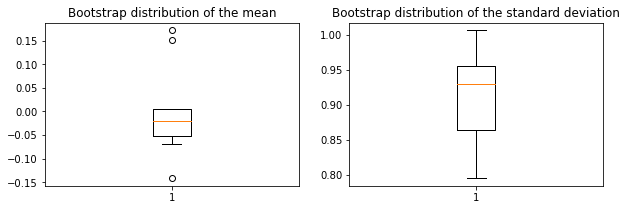

In [3]:
# Computing the bootstrap distribution for the mean and the variance
boot_mean = np.mean(bootstrap_sample,0)
boot_std = np.std(bootstrap_sample,0)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.boxplot([boot_mean])
plt.title('Bootstrap distribution of the mean')
plt.subplot(1,2,2)
plt.boxplot([boot_std])
plt.title('Bootstrap distribution of the standard deviation')
plt.show()

(Be careful not to mistake the standard deviation of the bootstrap estimate with the standard deviation estimated by bootstrap) 

In particular, the standard deviation of the bootstrap sampling distribution is an estimate of the standard error of the estimate.

Since the bootstrap distribution fully replace the underlying distribution of our data, we can apply standard statistical testing for inference. 

To obtain a confidence interval it is sufficient to order the bootstrap estimates $\hat{\theta\,}_{(a_1)}^*\leq \ldots \leq \hat{\theta\,}_{(a_B)}^*$, and compute the appropriate threshold for the statistical estimation.

For example, to calculate the $\alpha\%$ confidence interval for the statistic, we look for the bootstrap percentiles of our empirical distribution at $\alpha/2$ and $1-\alpha/2$. In our discrete setting, we compute the threshold $m = \alpha/2 * B$ and quantify the percentiles $(\hat{\theta\,}_{(m)}^*, \hat{\theta\,}_{(B-m)}^*)$. 

A $95\%$ confidence interval for the  bootstrap mean is:

In [4]:
# We compute a 95% confidence interval for the bootstrap mean
alpha = .05
m = alpha/2 * B

# Identifying our lower and upper quantiles
low = np.sort(boot_mean)[int(m)]
up = np.sort(boot_mean)[int(B-m)]

print('The ' + str(100-alpha) + '% confidence interval for the mean is [' 
      + str(low) + ' , ' + str(up) + ']')

The 99.95% confidence interval for the mean is [-0.14212785145208315 , 0.17229670446804643]


**Exercise.** Given the following data, estimate a 95% confidence interval for intercept and slope of the regression

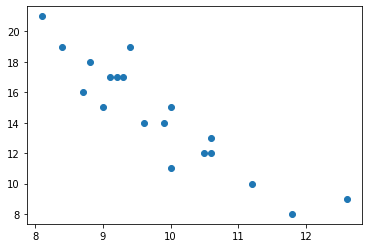

In [5]:
import pandas as pd

x = np.array([8.1, 8.4, 8.8, 8.7, 9, 9.1, 9.2, 9.3, 9.4, 9.6, 9.9, 10, 10, 10.5, 10.6, 10.6, 11.2, 11.8, 12.6])
y = np.array([21, 19, 18, 16, 15, 17, 17, 17, 19, 14, 14, 15, 11, 12, 12, 13, 10, 8, 9])

df = pd.DataFrame({'x': x, 'y':y})

plt.scatter(x,y)

In [9]:
from sklearn.linear_model import LinearRegression

interc = []
slope = []

N_bootstrap = 200

for i in range(N_bootstrap):
    idx  = np.random.choice(len(x), size = len(x) , replace = True)
    resamp_x = x[idx].reshape(-1,1)
    resamp_y = y[idx]
    reg = LinearRegression().fit(resamp_x, resamp_y)
    interc.append(reg.intercept_)
    slope.append(reg.coef_)

In [10]:
print('intercept: [2.5%, 50%, 97.5%] ',np.quantile(interc,[0.025, 0.5, 0.975]))
print('slope: [2.5%, 50%, 97.5%] ',np.quantile(slope,[0.025, 0.5, 0.975]))

intercept: [2.5%, 50%, 97.5%]  [35.83842905 42.64876632 48.68672523]
slope: [2.5%, 50%, 97.5%]  [-3.4626239  -2.85070976 -2.21376362]


In [11]:
# We verify against parameter estimation in OLS linear modeling

#!conda install -y statsmodels 
import statsmodels.api as sm
x_const = sm.add_constant(x)
model_all_data = sm.OLS(y, x_const).fit()
model_all_data.conf_int(alpha = 0.05)

array([[35.76273899, 48.81302247],
       [-3.4776445 , -2.15907642]])

### Hypothesis testing with boostrap

Consider a two-sample problem where $x \sim F$ and $y \sim G$, where we want to test the hypothesis $H_0 :\mathbf{E}(X)= \mathbf{E}(Y)$.  Hypothesis testing can be performed via bootstrapping, and the idea is to estimate F and G subject to the restriction that they must both have the same mean. Let's denote $\overline{z}$ the mean of the combined samples, let $F^0$ the empirical pdf of the points $\tilde{x_i} = {x_i} − \overline{x} + \overline{z}$ , and $G^0$ empirical pdf on the points $\tilde{y_i} = y_i − \overline{y} + \overline{z}$, where $\overline{z}$ is the mean of the combined sample. We note that by construction the distribution of $X$ and $Y$ are the same, with the exception of being translated around the same center, $\overline{z}$. 

We can therefore take B boostrap samples $\mathbf{x^*} = [\tilde{\mathbf{x}_1}^*, \ldots, \tilde{\mathbf{x}_B}^*]^T$ and $\mathbf{y^*} = [\tilde{\mathbf{y}_1}^*, \ldots, \tilde{\mathbf{y}_B}^*]^T$ by sampling with replacement from respectively $\mathbf{\tilde{x\,}}$ and $\mathbf{\tilde{y\,}}$. Under the hypothesis of equality of the means, we can therefore analyse the distribution of the quantity: 

$$ t_b^*  = \frac{\bar{\mathbf{x}}_b^* - \bar{\mathbf{y}}_b^*}{\sqrt{   \frac{{\hat{\sigma^*_{x_b}}}^2}{n} +  \frac{{\hat{\sigma^*_{y_b}}}^2}{m}  }},  $$

where $\bar{\mathbf{x}}_b^*$ and $\bar{\mathbf{y}}_b^*$ are the sampling mean for respectiely the bootstrap samples $\mathbf{x}_b^*$ and $\mathbf{y}_b^*$, while $\hat{\sigma^*_{xb}}^2$ and $\hat{\sigma^*_{xb}}^2$ are the variances. Here we are assuming normal populations with equals variances. Under these conditions the value $t_b^*$ is distributed accordin to the Behrens-Fisher distribution (https://en.wikipedia.org/wiki/Behrens–Fisher_distribution). 

Although this distribution takes a more complex for than the classical Student's _t_ one, under the bootstrapping regime this distribution can be empirically analyzed.

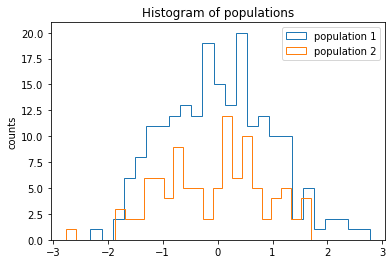

In [17]:
# We create 2 different populations
x = np.random.normal(size=200)
y = np.random.normal(size=100) - 0.1

n = len(x)
m = len(y)

plt.hist(x, 25, histtype='step', label = 'population 1')
plt.hist(y, 25, histtype='step', label = 'population 2')
plt.title('Histogram of populations')
plt.ylabel('counts')
plt.legend()
plt.show()

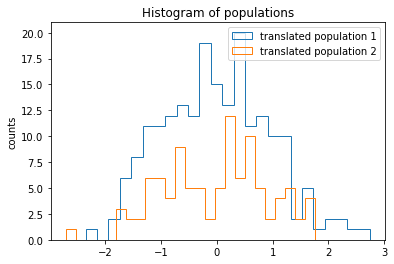

The mean of x_tilde is: -0.018725302909828975
The mean of y_tilde is: -0.018725302909828948

The variance of x_tilde is: 0.9163720448625661
The variance of y_tilde is: 0.8621775854144887

------------------------ 

The mean of x is: 0.01229104061031801
The mean of y is: -0.08075798995012294

The variance of x is: 0.9163720448625661
The variance of y is: 0.8621775854144887


In [18]:
def compute_t(x,y):
    n = len(x)
    m = len(y)
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    sigma2_x = np.var(x)
    sigma2_y = np.var(y)

    return( (mean_x - mean_y)/np.sqrt(sigma2_x/n + sigma2_y/m))

# Hypothesis testing
# E(X) = E(Y)

# Observed statistic
t_obs = compute_t(x,y)

# concatenated data for centering the distributions
z = np.concatenate([x, y])

mean_x = np.mean(x)
mean_y = np.mean(y)


# Translating the data around avg(z)
x_tilde = x - mean_x + np.mean(z)
y_tilde = y - mean_y + np.mean(z)


plt.hist(x_tilde, 25, histtype='step', label = 'translated population 1')
plt.hist(y_tilde, 25, histtype='step', label = 'translated population 2')
plt.title('Histogram of populations')
plt.ylabel('counts')
plt.legend()
plt.show()


print('The mean of x_tilde is: ' + str(np.mean(x_tilde)))
print('The mean of y_tilde is: ' + str(np.mean(y_tilde)))

print('\nThe variance of x_tilde is: ' + str(np.var(x_tilde)))
print('The variance of y_tilde is: ' + str(np.var(y_tilde)))


print('\n------------------------ \n\nThe mean of x is: ' + str(np.mean(x)))
print('The mean of y is: ' + str(np.mean(y)))

print('\nThe variance of x is: ' + str(np.var(x)))
print('The variance of y is: ' + str(np.var(y)))

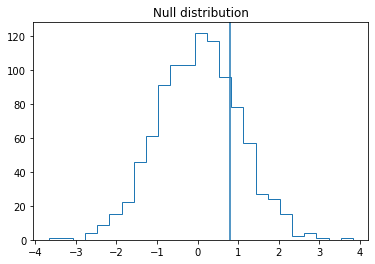

The bootstrap significance of the test is: 0.41600000000000004


In [19]:
# We now concatenate the centered data and sample from it
z_tilde = np.concatenate([x_tilde, y_tilde])

# Number of bootstrap samples
B = 1000

# We generate B samples 
b_sample = np.random.choice(z_tilde, (B, n+m), replace=True)

# For each pair of bootstrap samples we compute the associated statistic 
t_bootstrap = []
for i in range(B):
    x_simulated = b_sample[i,:n]
    y_simulated = b_sample[i,n:]
    t_bootstrap.append(compute_t(x_simulated, y_simulated))

# Plotting the null hypothesis distribution
plt.hist(t_bootstrap, 25, histtype='step')
plt.title('Null distribution')
plt.axvline(x = t_obs)
plt.show()

# Computing the significance of our test
bootstrap_stat = np.sum(np.abs(t_obs)>np.abs(t_bootstrap))/B

print('The bootstrap significance of the test is: ' + str(1-bootstrap_stat))

In [21]:
print('95% confidence interval for the null distribution: ',  np.quantile(t_bootstrap, [0.025, 0.975]))
print('observed statistic: ', t_obs)

95% confidence interval for the null distribution:  [-1.97792176  1.96235349]
observed statistic:  0.8097763334326162


What if we cannot make any assumption about the Gaussianity of the distributions? 
As before, let's $x\sim F$ and $y\sim G$. We are interested in testing a certain hypothesis $H_0$, for example $H_0: F=G$. Let's denote by $\mathbf{z}$ the combined data $\mathbf{x}$ and $\mathbf{x}$, we are interested in quantifying the significance level of  the quantity $T(\mathbf{z}) = \bar{\mathbf{x}} - \bar{\mathbf{y}}$:

$$ \mbox{Prob}_{H_0}\{ T(\mathbf{z}^*) \geq T(\mathbf{z}) \}$$

The flexibility of the bootstrap allows us to evaluate a significance for this kind of hypothesis testing. If $n$ and $m$ are the sample size of respectively $\mathbf{x}$ and $\mathbf{y}$, we can simply assign probablity $\frac{1}{(n+m)}$ on each member of the combined data $\mathbf{z}$. We can therefore evaluate the empirical null distribution $\hat{F_0}$ under $H_0$ for the random variable $\mathbf{z}^*$, providing a non-parameteric estimate of the common process that gave rise to both $\mathbf{x}$ and $\mathbf{y}$.

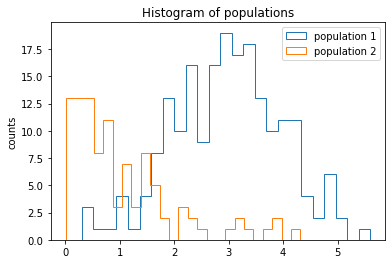

In [23]:
# We create 2 different populations, following different distributions
# The theory for parametric hypothesis testing cannot be used anymore
x = np.random.normal(size=200) + 3
y = np.random.exponential(size=100) 

plt.hist(x, 25, histtype='step', label = 'population 1')
plt.hist(y, 25, histtype='step', label = 'population 2')
plt.title('Histogram of populations')
plt.ylabel('counts')
plt.legend()
plt.show()

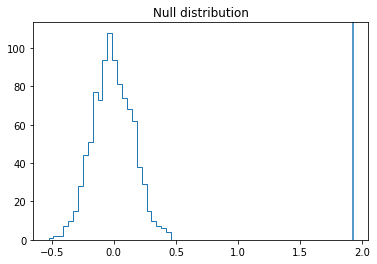

The bootstrap significance of the test is: 0.0


In [24]:
T = np.mean(x)-np.mean(y)

z = np.concatenate([x, y])

n = len(x)
m = len(y)

B = 1000
z_star = np.random.choice(z, (B, n+m), replace=True)

# For each pair of bootstrap samples we compute the associated statistic 
T_bootstrap = []
for i in range(B):
    synthetic_x = z_star[i,:n]
    synthetic_y = z_star[i,n:]
    T_bootstrap.append(np.mean(synthetic_x ) - np.mean(synthetic_y))

# Plotting the null hypothesis distribution
plt.hist(T_bootstrap, 25, histtype='step')
plt.title('Null distribution')
plt.axvline(x = T)
plt.show()

# Computing the significance of our test
bootstrap_stat = np.sum(np.abs(T)>np.abs(T_bootstrap))/B

print('The bootstrap significance of the test is: ' + str(1-bootstrap_stat))

**Exercise.** The following data reports the monthly rainfall during the months of June and November. Compute the null hypothesis for the rain fall distribution and assess whether there is any significant difference between the measurements in the two months

In [27]:
rain_june = np.array([ 66.2,  39.7,  76.4,  26.5,  11.2,  61.8,   6.1,  48.4,  89.2,
       104. ,  34. ,  60.6,  57.1,  79.1,  90.9,  32.3,  63.8,  78.2,
        27.5,  43.4,  30.1,  17.3,  77.5,  44.9,  92.2,  39.6,  79.4,
        66.1,  53.5,  98.5,  20.8,  55.5,  39.6,  56. ,  65.1,  14.8,
        13.2,  88.1,   8.4,  32.1,  19.6,  40.4,   2.2,  77.5, 105.4,
        77.2,  38. ,  27.1, 111.8,  17.2,  26.7,  23.3,  77.2,  87.2,
        27.7,  50.6,  60.3,  15.1,   6. ,  29.4,  39.3,  56.3,  80.4,
        85.3,  68.4,  72.5,  13.3,  28.4,  14.7,  37.4,  49.5,  57.2,
        85.9,  82.1,  31.8, 126.6,  30.7,  41.4,  33.9,  13.5,  99.1,
        70.2,  91.8,  61.3,  13.7,  54.9,  62.5,  24.2,  69.4,  83.1,
        44. ,  48.5,  11.9,  16.6,  66.4,  90. ,  34.9, 132.8,  33.4,
       225. ,   7.6,  40.9,  76.5,  48. , 140. ,  55.9,  54.1,  46.4,
        68.6,  52.2, 108.3,  14.6,  11.3,  29.8, 130.9, 152.4,  61. ,
        46.6,  43.9,  30.9, 111.1,  68.5,  42.2,   9.8, 285.6,  56.7,
       168.2,  41.2,  47.8, 166.6,  37.8,  45.4,  43.2])

rain_november = np.array([ 83.6,  30.9,  62.2,  37. ,  41. , 160.2,  18.2, 122.4,  71.3,
        44.2,  49.1,  37.6, 114.5,  28.8,  82.5,  71.9,  50.7,  67.7,
       112. ,  63.6,  42.8,  57.2,  99.1,  86.4,  84.4,  38.1,  17.7,
       102.2, 101.3,  58. ,  82. , 101.4,  81.4, 100.1,  54.6,  39.6,
        57.5,  29.2,  48.8,  37.3, 115.4,  55.6,  62. ,  95. ,  84.2,
       118.1, 153.2,  83.4, 104.7,  59. ,  46.4,  50. , 147.6,  76.8,
        59.9, 101.8, 136.6, 173. ,  92.5,  37. ,  59.8, 142.1,   9.9,
       158.2,  72.6,  28. , 112.9, 119.3, 199.2,  50.7,  44. , 170.7,
        67.2,  21.4,  61.3,  15.6, 106. , 116.2,  42.3,  38.5, 132.5,
        40.8, 147.5,  93.9,  71.4,  87.3, 163.7, 141.4,  62.6,  84.9,
        28.8, 121.1,  28.6,  32.4, 112. ,  50. ,  96.9,  81.8,  70.4,
       117.5,  41.2, 124.9,  78.2,  93. ,  53.5,  50.5,  42.6,  47.9,
        73.1, 129.1,  56.9, 103.3,  60.5, 134.3,  93.1,  49.5,  48.2,
       167.9,  27. , 111.1,  55.4,  36.2,  57.4,  66.8,  58.3,  60. ,
       161.6, 112.7,  37.4, 110.6,  56.6,  95.8, 126.8])


In [33]:
def boostrap_groups(x,y, B = 1):
    z = np.concatenate([x, y])
    diff_boostrap =np.empty(B)
    for i in range(B):
        permuted_data = np.random.choice(z, len(z), replace = True)
        perm_sample_1 = permuted_data[:len(x)]
        perm_sample_2 = permuted_data[len(x):]
        diff_boostrap[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)
    real_diff = np.mean(x) - np.mean(y)
    print('Avg x: ', np.mean(x))
    print('Avg y: ', np.mean(y))
    print('statistical test for the difference (p-value): ', np.sum(real_diff>diff_boostrap)/B)
    plt.hist(diff_boostrap, 25, histtype='step')
    plt.title('Null distribution')
    plt.axvline(x = real_diff)
    plt.show()

Avg x:  58.16015037593985
Avg y:  79.27443609022556
statistical test for the difference (p-value):  0.0


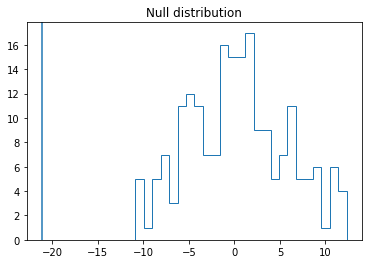

In [34]:
boostrap_groups(rain_june,rain_november,200)

**Exercise.** During the vote for the  Civil Rights Act of 1964, 152 House Democrats and 138 Republicans voted yes, while 96 Democrats and 34 Republicans voted no. Did party affiliation make a difference in the vote?

Statistic for the ratio:  0.0


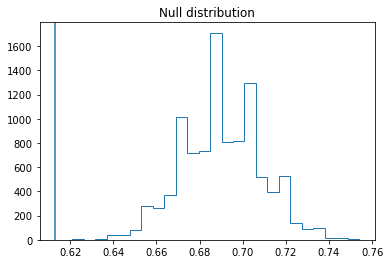

In [81]:
dems = np.array([True] * 152 + [False] * 96)
reps = np.array([True] * 138 + [False] * 34)

def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = np.sum(dems) / len(dems) - np.sum(reps) / len(reps)
    return frac

def boostrap_votes(x,y, size = 1):
    z = np.concatenate([x, y])
    ratio_boostrap = np.empty(size)
    for i in range(size):
        permuted_data = np.random.choice(z, len(z), replace = True)
        dems = permuted_data[:len(x)]
        reps = permuted_data[len(x):]
        ratio_boostrap[i] = frac_yea_dems(dems,reps)
    real_ratio = frac_yea_dems(x,y)

    print('Statistic for the ratio: ', np.sum(real_ratio>ratio_boostrap)/size)
    plt.hist(ratio_boostrap, 25, histtype='step')
    plt.title('Null distribution')
    plt.axvline(x = real_ratio)
    plt.show()


# Acquire permutation samples: perm_replicates
boostrap_votes(dems, reps, 10000)

**Exercise.** Back to the data seen before, we want to compare a linear model to a qudratic one. Use bootstrap to decide whether a quadratic model is preferable over the linear one (or viceversa)

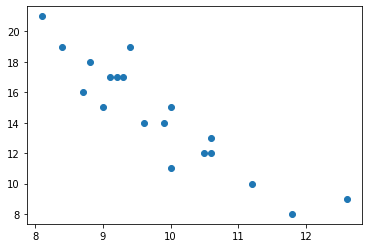

In [104]:
x = np.array([8.1, 8.4, 8.8, 8.7, 9, 9.1, 9.2, 9.3, 9.4, 9.6, 9.9, 10, 10, 10.5, 10.6, 10.6, 11.2, 11.8, 12.6])
y = np.array([21, 19, 18, 16, 15, 17, 17, 17, 19, 14, 14, 15, 11, 12, 12, 13, 10, 8, 9])

plt.scatter(x,y)

In [155]:
from sklearn.preprocessing import PolynomialFeatures 

coef_lin = []
coef_poly = []

test_point = np.array(14).reshape(-1,1)
pred_test_lin = []
pred_test_poly = []

for i in range(200):
    idx  = np.random.choice(len(df), size = len(df) , replace = True)
    
    reg = LinearRegression().fit(x[idx].reshape(-1,1), y[idx])
    coef_lin.append(reg.coef_)
    pred_test_lin.append(reg.predict(test_point).item())
    
    poly = PolynomialFeatures(2)
    x_poly = poly.fit_transform(x[idx].reshape(-1,1))
    reg_poly = LinearRegression().fit(x_poly, y[idx].reshape(-1,1))
    coef_poly.append(reg_poly.coef_)
    pred_test_poly.append(reg_poly.predict(poly.fit_transform(test_point)).item())
    


In [162]:
print(5*'#' + ' Assessing mean/var of the coefficients' + 5*'#' )
print('\nlinear model')
print(np.mean(coef_lin,0))
print(np.var(coef_lin,0))

print('\nquadratic model')
print(np.mean(coef_poly,0))
print(np.var(coef_poly,0))

##### Assessing mean/var of the coefficients#####

linear model
[-2.89171306]
[0.11815332]

quadratic model
[[ 0.         -7.16944765  0.20600086]]
[[ 0.         38.48701946  0.09735435]]


In [166]:
print(5*'#' + ' Assessing mean/var of the prediction of the test point x = ' + str(test_point.item()) + ' '  + 5*'#' )

print('\nlinear model')
print(np.mean(pred_test_lin,0))
print(np.var(pred_test_lin,0))

print('\nquadratic model')
print(np.mean(pred_test_poly,0))
print(np.var(pred_test_poly,0))


##### Assessing mean/var of the prediction of the test point x = 14 #####

linear model
2.5184176000502014
2.2052382886710378

quadratic model
4.835678836480747
24.792910850496437


# Bagging

So far we used a learning set $ \mathcal{D} = \{(y_n, \mathbf{x}_n)\}_1^N$ to fit a predictor $\hat{f\,}(\mathbf{x})$. With bagging we assume that we have a sequence of learning sets $ \{\mathcal{D}_k\}$ each consisting of $N$ independent observations from the same underlying distribution. We can use this sequence to improve our prediction. A simple scheme would consist in boostrapping the original data to create new learning sets $ \{\mathcal{D}_k^B\}$, and taking the average of predictors independently trained:

$$ f_B(\mathbf{x}) = \mathbf{E}_\mathcal{\mbox{bootstrap}}[f(\mathbf{x})|\mathcal{D}^B].$$

Similarly, if $f$ is a classifiers, we could just aggregate the predictions by voting. This operation is called  __bagging__ (__b__ootstrap __agg__regat__ing__). Other kind of aggregating mechanism can be used, for example by taking the _median_ of the predictions (also known as _bragging_).

Example:

In [ ]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

# We apply bagging to a KNN classifier 
kn =  KNeighborsClassifier(3)

# Number of data samples 
n_samples = 2000

# We create a binary classification problem with 10 features and n_samples data samples
X, y = make_classification(n_samples = n_samples, class_sep = 0.1, weights = [.5,.5], n_features=10, n_informative = 6,
                           n_redundant=0, n_clusters_per_class=1)

# We split the data in 50% training data
train_size = 500

train_data = X[:train_size,:], y[:train_size]
test_data = X[train_size:,:], y[train_size:]

no_bagging_prediction_on_test_data = []

# We fit the classifier on the train data
kn.fit(train_data[0], train_data[1])
# We compute the predictions
no_bagging_prediction_on_test_data.append(kn.predict(test_data[0]))

# In what follows we apply bagging to the prediction of our KNN classifier
# To this end, we need sample from the training data with repetition, and fit a different classifier 
# on the newly generated dataset

voting = []    
prediction_on_test_data = []

# Number of bootstrap iterations
B = 1000
    
for i in range(B):
    # We select random positions, with repetition, from the positions of the training data
    idx = np.random.choice(range(len(train_data[1])), len(train_data[1]), replace = True)        
    # We sample the training data on the selected positions from the original training data matrix
    current_data = train_data[0][idx,:], train_data[1][idx]
    # We fit the classifier on the boostrapped training data
    kn.fit(current_data[0], current_data[1])        
    # We compute the prediction on the testing data
    prediction_on_test_data.append(kn.predict(test_data[0]))
      
# Here we compute the mean prediction across bootstrap iterations
voting.append(np.mean(prediction_on_test_data,0))

# The bagging prediction is the one getting the majority of votes 
bagging_prediction = [round(voting[0][i],0) for i in range(n_samples - train_size)]


In [170]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('-- standard prediction --\n')
print('accuracy: ' + str(accuracy_score(test_data[1],no_bagging_prediction_on_test_data[0])))
print('precision: ' + str(precision_score(test_data[1],no_bagging_prediction_on_test_data[0])))
print('sensitivity: ' + str(recall_score(test_data[1],no_bagging_prediction_on_test_data[0])))


print('\n-- bagging prediction --\n')
print('accuracy: ' + str(accuracy_score(test_data[1],bagging_prediction)))
print('precision: ' + str(precision_score(test_data[1],bagging_prediction)))
print('sensitivity: ' + str(recall_score(test_data[1],bagging_prediction)))


-- standard prediction --

accuracy: 0.7
precision: 0.6833013435700576
sensitivity: 0.725050916496945

-- bagging prediction --

accuracy: 0.709
precision: 0.6915708812260536
sensitivity: 0.7352342158859471
